In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve, classification_report
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('./data/data.json', lines=True)
labels = pd.read_csv('./data/labels.info', sep=',')

### Writing a function to harvest the data into a working dataframe

In [3]:
def get_dataframe(df):
    transcripts = df.columns
    dataframes = []
    for transcript in transcripts:
        df_curr_transcript = df.loc[:, transcript]
        df_curr_transcript.dropna(inplace=True)
        df_curr_transcript = list(df_curr_transcript)
        
        for position in df_curr_transcript:
            #position here is a dictionary
            for k1, v1, in position.items():
                order = list(v1.keys())[0]
                for k2, v2 in v1.items():
                    left_order = k2[:5]
                    centre_order = k2[1:6]
                    right_order = k2[len(k2)-5:]
                    
                    num_lists = len(v2)

                    left_dwelling_t = 0
                    left_sd = 0
                    left_mean = 0

                    centre_dwelling_t = 0
                    centre_sd = 0
                    centre_mean = 0
                    
                    right_dwelling_t = 0
                    right_sd = 0
                    right_mean = 0

                    for read in v2:
                        left_dwelling_t += read[0]
                        left_sd += read[1]
                        left_mean += read[2]

                        centre_dwelling_t += read[3]
                        centre_sd += read[4]
                        centre_mean += read[5]
                        
                        right_dwelling_t += read[6]
                        right_sd += read[7]
                        right_mean += read[8]

                    left_dwelling_t /= num_lists
                    left_sd /= num_lists
                    left_mean /= num_lists

                    centre_dwelling_t /= num_lists
                    centre_sd /= num_lists
                    centre_mean /= num_lists
                    
                    right_dwelling_t /= num_lists
                    right_sd /= num_lists
                    right_mean /= num_lists
                    

                curr_dataframe = pd.DataFrame({'transcript_id':[transcript], 'order': [order], 'curr_pos': [k1], 'left_order': [left_order], 'avg_left_dwelling_t': [left_dwelling_t], 'avg_left_sd': [left_sd], 
                                            'avg_left_mean': [left_mean], 'centre_order': [centre_order], 'avg_centre_dwelling_t': [centre_dwelling_t], 'avg_centre_sd': [centre_sd], 'avg_centre_mean': [centre_mean], 
                                            'right_order': [right_order], 'avg_right_dwelling_t': [right_dwelling_t], 'avg_right_sd': [right_sd], 'avg_right_mean': [right_mean]})   
                dataframes.append(curr_dataframe)
    final_df = pd.concat(dataframes)
    final_df['curr_pos'] = final_df['curr_pos'].astype('int64')
    return final_df 

In [4]:
df1 = get_dataframe(df)

### Play with df1

### Encoding

In [5]:
df1 = pd.merge(df1, labels, how='left',left_on=['transcript_id', 'curr_pos'], right_on=['transcript_id', 'transcript_position'])
df1 = df1.drop(['transcript_position'], axis='columns')

In [6]:
df2 = df1.copy()
df2['left_1'] = df2['left_order'].apply(lambda x: x[0])
df2['left_2'] = df2['left_order'].apply(lambda x: x[1])
df2['left_3'] = df2['left_order'].apply(lambda x: x[2])
df2['left_4'] = df2['left_order'].apply(lambda x: x[3])
df2['left_5'] = df2['left_order'].apply(lambda x: x[4])

df2['centre_1'] = df2['centre_order'].apply(lambda x: x[0])
df2['centre_2'] = df2['centre_order'].apply(lambda x: x[1])
df2['centre_3'] = df2['centre_order'].apply(lambda x: x[2])
df2['centre_4'] = df2['centre_order'].apply(lambda x: x[3])
df2['centre_5'] = df2['centre_order'].apply(lambda x: x[4])

df2['right_1'] = df2['right_order'].apply(lambda x: x[0])
df2['right_2'] = df2['right_order'].apply(lambda x: x[1])
df2['right_3'] = df2['right_order'].apply(lambda x: x[2])
df2['right_4'] = df2['right_order'].apply(lambda x: x[3])
df2['right_5'] = df2['right_order'].apply(lambda x: x[4])

In [7]:
df2

,transcript_id,order,curr_pos,left_order,avg_left_dwelling_t,avg_left_sd,avg_left_mean,centre_order,avg_centre_dwelling_t,avg_centre_sd,...,centre_1,centre_2,centre_3,centre_4,centre_5,right_1,right_2,right_3,right_4,right_5
0,ENST00000000233,AAGACCA,244,AAGAC,0.008264,4.223784,123.702703,AGACC,0.009373,7.382162,...,A,G,A,C,C,G,A,C,C,A
1,ENST00000000233,CAAACTG,261,CAAAC,0.006609,3.216424,109.681395,AAACT,0.006813,3.226535,...,A,A,A,C,T,A,A,C,T,G
2,ENST00000000233,GAAACAG,316,GAAAC,0.007570,2.940541,105.475676,AAACA,0.007416,3.642703,...,A,A,A,C,A,A,A,C,A,G
3,ENST00000000233,AGAACAT,332,AGAAC,0.010620,6.476350,129.355000,GAACA,0.008632,2.899200,...,G,A,A,C,A,A,A,C,A,T
4,ENST00000000233,AGGACAA,368,AGGAC,0.010701,6.415051,117.924242,GGACA,0.011479,5.870303,...,G,G,A,C,A,G,A,C,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,GGGACAT,1348,GGGAC,0.009594,3.294164,118.232877,GGACA,0.007300,4.929726,...,G,G,A,C,A,G,A,C,A,T
121834,ENST00000641834,CTGACAC,1429,CTGAC,0.008393,4.511014,110.969565,TGACA,0.010305,9.105797,...,T,G,A,C,A,G,A,C,A,C
121835,ENST00000641834,TGGACAC,1531,TGGAC,0.008161,3.918438,113.968750,GGACA,0.006877,4.759687,...,G,G,A,C,A,G,A,C,A,C
121836,ENST00000641834,CTGACCA,1537,CTGAC,0.008044,3.191228,109.354386,TGACC,0.007419,6.552982,...,T,G,A,C,C,G,A,C,C,A


In [11]:
df2.columns

Index(['transcript_id', 'order', 'curr_pos', 'left_order',
       'avg_left_dwelling_t', 'avg_left_sd', 'avg_left_mean', 'centre_order',
       'avg_centre_dwelling_t', 'avg_centre_sd', 'avg_centre_mean',
       'right_order', 'avg_right_dwelling_t', 'avg_right_sd', 'avg_right_mean',
       'gene_id', 'label', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5',
       'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_1',
       'right_2', 'right_3', 'right_4', 'right_5'],
      dtype='object')

In [12]:
df2.loc[:, ['left_order', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5']]

,left_order,left_1,left_2,left_3,left_4,left_5
0,AAGAC,A,A,G,A,C
1,CAAAC,C,A,A,A,C
2,GAAAC,G,A,A,A,C
3,AGAAC,A,G,A,A,C
4,AGGAC,A,G,G,A,C
...,...,...,...,...,...,...
121833,GGGAC,G,G,G,A,C
121834,CTGAC,C,T,G,A,C
121835,TGGAC,T,G,G,A,C
121836,CTGAC,C,T,G,A,C


In [13]:
#categorical data
categorical_cols = ['left_1', 'left_2', 'left_3', 'left_4', 'left_5',
       'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_1',
       'right_2', 'right_3', 'right_4', 'right_5']

#import pandas as pd
df3 = pd.get_dummies(df2, columns = categorical_cols)

Now, there could be a case where the letters A,C,G,T is not found in the column and could be found in the unknown test set. So we need to introduce that column. 

In [15]:
expected_columns = ['left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
                    'left_2_A', 'left_2_C', 'left_2_G', 'left_2_T', 
                    'left_3_A', 'left_3_C', 'left_3_G', 'left_3_T', 
                    'left_4_A', 'left_4_C', 'left_4_G', 'left_4_T', 
                    'left_5_A', 'left_5_C', 'left_5_G', 'left_5_T',
                    'centre_1_A', 'centre_1_C', 'centre_1_G', 'centre_1_T', 
                    'centre_2_A', 'centre_2_C', 'centre_2_G', 'centre_2_T', 
                    'centre_3_A', 'centre_3_C', 'centre_3_G', 'centre_3_T', 
                    'centre_4_A', 'centre_4_C', 'centre_4_G', 'centre_4_T', 
                    'centre_5_A', 'centre_5_C', 'centre_5_G', 'centre_5_T',
                    'right_1_A', 'right_1_C', 'right_1_G', 'right_1_T', 
                    'right_2_A', 'right_2_C', 'right_2_G', 'right_2_T', 
                    'right_3_A', 'right_3_C', 'right_3_G', 'right_3_T',  
                    'right_4_A', 'right_4_C', 'right_4_G', 'right_4_T', 
                    'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T']

In [19]:
df3_cols = df3.columns
for col in expected_columns:
    if col not in df3_cols:
        df3[col] = [0 for i in range(len(df3))]

In [24]:
df4 = df3.drop(['transcript_id', 'order', 'left_order', 'centre_order', 'right_order', 'gene_id'], axis=1)

### Train test split

In [25]:
labels

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0
...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,1
121834,ENSG00000167747,ENST00000641834,1429,0
121835,ENSG00000167747,ENST00000641834,1531,1
121836,ENSG00000167747,ENST00000641834,1537,0


In [26]:
labels.label.value_counts()[0]/labels.label.value_counts()[1]

21.25351598173516

There are 21 times more zeroes than 1's. 

In [43]:
genes = list(labels['gene_id'].unique())

In [44]:
train_genes, test_genes = train_test_split(genes, train_size = 0.8, random_state=42)

In [45]:
train_labels = labels[labels['gene_id'].isin(train_genes)]
test_labels = labels[labels['gene_id'].isin(test_genes)]

In [46]:
train_labels.label.value_counts()[0]/train_labels.label.value_counts()[1]

20.6593603220756

In [47]:
test_labels.label.value_counts()[0]/test_labels.label.value_counts()[1]

23.899402390438247

Wow the imbalance in the split is still present and is roughly the same in both train and test and original. Nice.

In [48]:
train_labels

,gene_id,transcript_id,transcript_position,label
18,ENSG00000003056,ENST00000000412,355,0
19,ENSG00000003056,ENST00000000412,367,0
20,ENSG00000003056,ENST00000000412,496,0
21,ENSG00000003056,ENST00000000412,501,0
22,ENSG00000003056,ENST00000000412,547,0
...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,1
121834,ENSG00000167747,ENST00000641834,1429,0
121835,ENSG00000167747,ENST00000641834,1531,1
121836,ENSG00000167747,ENST00000641834,1537,0


In [52]:
X_train = pd.merge(train_labels, df3, how='inner',left_on=['gene_id', 'transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])
X_test = pd.merge(test_labels, df3, how='inner',left_on=['gene_id','transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])

In [53]:
y_train = np.asarray(X_train['label'])
y_test = np.asarray(X_test['label'])

In [54]:
X_train = X_train.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order', 'left_order', 'centre_order', 'right_order'], axis=1)
X_test = X_test.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order', 'left_order', 'centre_order', 'right_order'], axis=1)

In [55]:
X_train

,curr_pos,avg_left_dwelling_t,avg_left_sd,avg_left_mean,avg_centre_dwelling_t,avg_centre_sd,avg_centre_mean,avg_right_dwelling_t,avg_right_sd,avg_right_mean,...,centre_5_G,right_1_C,right_1_T,right_2_C,right_2_G,right_2_T,right_3_A,right_3_G,right_3_T,right_4_G
0,355,0.007340,2.977180,108.360000,0.007782,2.608600,106.584000,0.007045,1.888520,94.174000,...,0,0,0,0,0,0,0,0,0,0
1,367,0.008988,3.961489,118.638298,0.007403,6.045319,122.489362,0.006636,3.112340,83.229787,...,0,0,0,0,0,0,0,0,0,0
2,496,0.011065,7.299608,115.549020,0.009377,5.986667,125.666667,0.006474,2.857647,89.605882,...,0,0,0,0,0,0,0,0,0,0
3,501,0.006904,2.803571,119.142857,0.010334,5.950893,123.821429,0.010214,2.679821,90.810714,...,0,0,0,0,0,0,0,0,0,0
4,547,0.006961,4.949231,108.373077,0.009155,5.005962,123.750000,0.011251,4.740577,83.025000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96834,1348,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,0.006555,4.005616,82.004110,...,0,0,0,0,0,0,0,0,0,0
96835,1429,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,0.005568,3.644638,80.497101,...,0,0,0,0,0,0,0,0,0,0
96836,1531,0.008161,3.918438,113.968750,0.006877,4.759687,113.562500,0.006410,2.181562,84.190625,...,0,0,0,0,0,0,0,0,0,0
96837,1537,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,0.006472,2.540877,82.289474,...,0,0,0,0,0,0,0,0,0,0


### Hi ppl, yall can use the code till here. Below can be done in many ways and feel free to do ur own way. 

### Split training set into train and validation

In [ ]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
### Check whether the split gave a good imbalance
dic = defaultdict(lambda: 0)
for value in y_valid:
    dic[value] += 1
print(dic[0]/dic[1])

dic = defaultdict(lambda: 0)
for value in y_training:
    dic[value] += 1
print(dic[0]/dic[1])


22.16052318668252
21.241507279474735


Let us perform smote on the training data. 

In [ ]:
oversample = SMOTE(random_state=42)
X_training_smote, y_training_smote = oversample.fit_resample(X_training, y_training)

Let us now scale the training smote data and validation data

In [ ]:
scaler_training = MinMaxScaler()
scaled_X_training_smote = scaler_training.fit_transform(X_training_smote)
scaled_X_validation = scaler_training.transform(X_valid)

We now have the following datasets to train and validate with:
- X_train: scaled_X_training_smote
- y_train: y_training_smote
- X_valid: scaled_X_validation
- y_valid: y_valid

### Modelling

In [ ]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = ['auc', 'precision']
eval_set = [(scaled_X_training_smote, y_training_smote), (scaled_X_validation, y_valid)]
xgb_clf = XGBClassifier()
xgb_clf.fit(scaled_X_training_smote, y_training_smote, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)
y_pred = xgb_clf.predict(scaled_X_validation)


accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
probs = xgb_clf.predict_proba(scaled_X_validation)[:, 1]
rocauc = roc_auc_score(y_valid, probs)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("ROCAUC: %.2f%%" % (rocauc * 100.0))

c:\Users\xyber\anaconda3\envs\sanraj1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.20262	validation_0-logloss:0.57694	validation_1-error:0.24094	validation_1-logloss:0.58165
[1]	validation_0-error:0.16360	validation_0-logloss:0.50272	validation_1-error:0.16193	validation_1-logloss:0.50989
[2]	validation_0-error:0.15843	validation_0-logloss:0.45359	validation_1-error:0.16578	validation_1-logloss:0.46162
[3]	validation_0-error:0.15146	validation_0-logloss:0.42162	validation_1-error:0.16187	validation_1-logloss:0.43161
[4]	validation_0-error:0.13276	validation_0-logloss:0.38421	validation_1-error:0.15381	validation_1-logloss:0.39684
[5]	validation_0-error:0.12996	validation_0-logloss:0.36365	validation_1-error:0.14873	validation_1-logloss:0.37763
[6]	validation_0-error:0.12632	validation_0-logloss:0.34430	validation_1-error:0.14688	validation_1-logloss:0.35785
[7]	validation_0-error:0.12004	validation_0-logloss:0.32747	validation_1-error:0.13354	validation_1-logloss:0.34048
[8]	validation_0-error:0.11765	validation_0-logloss:0.31777	validation_1

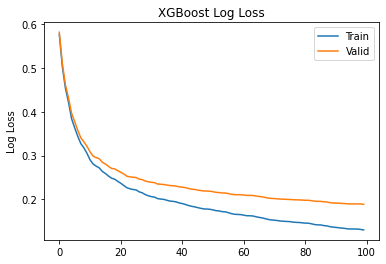

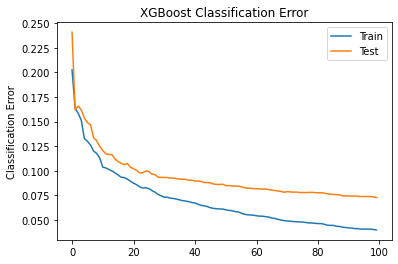

In [ ]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Valid')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

### Scale the data

In [ ]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Note that we do not need to specify the categorical columns when scaling because it won't change it's values

In [ ]:
dic = defaultdict(lambda: 0)
for value in y_train:
    dic[value] += 1
print(dic[0]/dic[1])


21.419429097605892
